In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math

import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set_theme(style='whitegrid')

from datetime import datetime

from utils.bs_funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
## download stock data
ticker = 'BOVA11'
yf_ticker = [f'{ticker}.SA']
df =  get_stock_data(yf_ticker, period='1Y')
window_size = 20

[*********************100%%**********************]  1 of 1 completed


In [3]:
cc_vol = realized_cc_vol(df['Close'])
print(f'Close-to-Close Volatility: {cc_vol:.2%}')

Close-to-Close Volatility: 13.71%


In [4]:
rolling_cc_volatility = []

for i in range(len(df) - window_size + 1):
    window = df['Close'].iloc[i:i + window_size]
    vol = realized_cc_vol(window)
    rolling_cc_volatility.append(vol)

In [5]:
def parkinson_volatility(df):
     N = df.shape[0]
     k = (1/(4 * N * np.log(2)))
     hi_lo = np.sum(np.log(df['High'] / df['Low']) ** 2)
     
     return np.sqrt(k*hi_lo) * np.sqrt(252)
 
park_vol = parkinson_volatility(df)
print(f'Parkinson Vol: {park_vol:.2%}')

Parkinson Vol: 11.50%


In [6]:
rolling_parkinson_volatility = []

for i in range(len(df) - window_size + 1):
    window = df.iloc[i:i + window_size]
    vol = parkinson_volatility(window)
    rolling_parkinson_volatility.append(vol)


In [7]:
def yz_volatility(df, dte=len(df)): ## FIX
    N = df.shape[1]
    if dte == None:
        dte = N
    df = df[-dte:-1]
    open = df['Open']
    close = df['Close']
    hi = df['High']
    lo = df['Low']
    
    sigma_open = (1 / N -1 ) * np.sum([np.log(open.iloc[i] / open.iloc[i-1]) - 1 / N * np.sum(np.log(open.iloc[i] / open.iloc[i-1]) ) for i, o in enumerate(open)]) ** 2
    sigma_close = (1 / N -1 ) * (np.sum([np.log(close.iloc[i] / close.iloc[i-1]) - 1 / N * np.sum(np.log(close.iloc[i] / close.iloc[i-1]) ) for i, o in enumerate(close)]) ** 2)
    sigma_hilo = (1 / N ) * np.sum([np.log(hi.iloc[i] / close.iloc[i-1]) * np.log(hi.iloc[i] / open.iloc[i-1]) + np.log(lo.iloc[i] / close.iloc[i-1]) * np.log(lo.iloc[i] / open.iloc[i-1]) for i, o in enumerate(close)])
    k = 0.34 / (1.34 + (N+1) / (N-1) )
    
    yz_vol = np.sqrt(sigma_open + k*sigma_close + (1 - k)*sigma_hilo) 
    
    return yz_vol * np.sqrt(dte/252)

yz_vol = yz_volatility(df, 252)
print(f'Yang-Zhang Vol: {yz_vol:.2%}')

Yang-Zhang Vol: 8.19%


In [8]:
rolling_yz_volatility = []

for i in range(len(df) - window_size + 1):
    window = df.iloc[i:i + window_size]
    vol = yz_volatility(window)
    rolling_yz_volatility.append(vol)
    
rolling_yz_volatility_100 = np.array(rolling_yz_volatility) * 5

### PLOTS

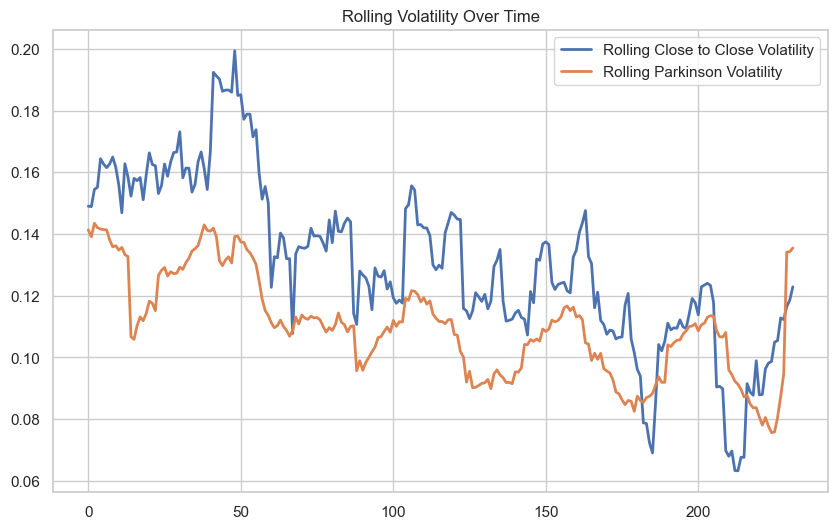

In [9]:
plt.figure(figsize=(10, 6))

# Plot rolling volatility
plt.plot(rolling_cc_volatility, label='Rolling Close to Close Volatility', linewidth=2)
plt.plot(rolling_parkinson_volatility, label='Rolling Parkinson Volatility', linewidth=2)
# plt.plot(rolling_yz_volatility_100, label='Rolling Yang-Zhang Volatility', linewidth=2)


# Add titles and labels
plt.title('Rolling Volatility Over Time')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()